<a href="https://colab.research.google.com/github/megcp/Research-project-sentiment-driven-stock-market-prediction/blob/main/RP8_Finbert_model_evaulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.3 MB/s eta 0:00:00


In [ ]:
!pip install -U textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1


In [ ]:
# importing dependencies
import pandas as pd
import numpy as np
import json
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import contractions
import re
from nltk.tokenize import word_tokenize
from textblob import TextBlob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Research Project/LLM_evaulation.csv')

In [ ]:
data.head()

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


In [ ]:
# extract sentiment from the desicions
def extract_sentiment(decisions_str):
    decisions_dict = json.loads(decisions_str)
    for entity, sentiment in decisions_dict.items():
        return sentiment

data['Sentiment'] = data['Decisions'].apply(extract_sentiment)

In [ ]:
# check for data imbalance - its fairly evean
data['Sentiment'].value_counts()

Sentiment
positive    4170
neutral     3444
negative    3139
Name: count, dtype: int64

In [ ]:
data.head()

,S No.,Title,Decisions,Words,Sentiment
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8,neutral
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8,neutral
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8,positive
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7,positive
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8,neutral


In [ ]:
data.dropna(inplace=True)

In [ ]:
data = data.reset_index()

In [ ]:
data.drop(columns=['index', 'S No.', 'Decisions', 'Words'], inplace=True)

In [ ]:
X = data['Title'].to_list()

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# load FinBERT-tone model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
# create labels for the numeric outputs
labels = {0:'neutral', 1:'positive',2:'negative'}
texts = []
sentiment_labels = []
sentiment_probs = []

# iterate through each text
for x in X:
    # tokenize the text
    inputs = tokenizer(x, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Pass the input to the FinBERT model
    outputs = model(**inputs)[0]
    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(outputs, dim=1).detach().cpu().numpy().flatten()
    # Get  highest probability
    sentiment_label = labels[np.argmax(probs)]
    texts.append(x)
    sentiment_labels.append(sentiment_label)
    sentiment_probs.append(probs)


df1 = pd.DataFrame({
    'Title': texts,
    'Sentiment_title': sentiment_labels,
    'Neutral_Prob_title': [prob[0] for prob in sentiment_probs],
    'Positive_Prob_title': [prob[1] for prob in sentiment_probs],
    'Negative_Prob_title': [prob[2] for prob in sentiment_probs]
})

In [ ]:
df1

,Title,Sentiment_title,Neutral_Prob_title,Positive_Prob_title,Negative_Prob_title
0,SpiceJet to issue 6.4 crore warrants to promoters,neutral,0.999408,1.275361e-04,0.000464
1,MMTC Q2 net loss at Rs 10.4 crore,negative,0.011055,1.384194e-05,0.988932
2,"Mid-cap funds can deliver more, stay put: Experts",positive,0.002056,9.979389e-01,0.000005
3,Mid caps now turn into market darlings,neutral,0.999971,7.638381e-07,0.000028
4,"Market seeing patience, if not conviction: Pra...",positive,0.297568,6.955885e-01,0.006843
...,...,...,...,...,...
10748,"Negative on Chambal, Advanta: Mitesh Thacker",negative,0.000005,1.503757e-06,0.999993
10749,"Small, Mid-cap stocks may emerge outperformers",positive,0.000039,9.999597e-01,0.000001
10750,Rupee slips against US dollar,negative,0.016567,8.587216e-05,0.983347
10751,Rupee weak against US dollar,negative,0.000047,1.249650e-05,0.999941


In [ ]:
df1.rename(columns={'Sentiment_title':'Predicted sentiment'}, inplace= True)
data.rename(columns={'Sentiment':'Actual sentiment'}, inplace= True)
df_merged = pd.merge(data, df1, on='Title')
df_merged

,Title,Actual sentiment,Predicted sentiment,Neutral_Prob_title,Positive_Prob_title,Negative_Prob_title
0,SpiceJet to issue 6.4 crore warrants to promoters,neutral,neutral,0.999408,1.275361e-04,0.000464
1,MMTC Q2 net loss at Rs 10.4 crore,neutral,negative,0.011055,1.384194e-05,0.988932
2,"Mid-cap funds can deliver more, stay put: Experts",positive,positive,0.002056,9.979389e-01,0.000005
3,Mid caps now turn into market darlings,positive,neutral,0.999971,7.638381e-07,0.000028
4,"Market seeing patience, if not conviction: Pra...",neutral,positive,0.297568,6.955885e-01,0.006843
...,...,...,...,...,...,...
10882,"Negative on Chambal, Advanta: Mitesh Thacker",negative,negative,0.000005,1.503757e-06,0.999993
10883,"Small, Mid-cap stocks may emerge outperformers",positive,positive,0.000039,9.999597e-01,0.000001
10884,Rupee slips against US dollar,negative,negative,0.016567,8.587216e-05,0.983347
10885,Rupee weak against US dollar,negative,negative,0.000047,1.249650e-05,0.999941


In [ ]:
accuracy = accuracy_score(df_merged['Actual sentiment'], df_merged['Predicted sentiment'])
print("Accuracy Score:", accuracy)

Accuracy Score: 0.6784238082116285


In [ ]:
cm = confusion_matrix(df_merged['Actual sentiment'], df_merged['Predicted sentiment'])

In [ ]:
print(cm)

[[1998 1047  118]
 [ 245 2979  297]
 [ 199 1595 2409]]


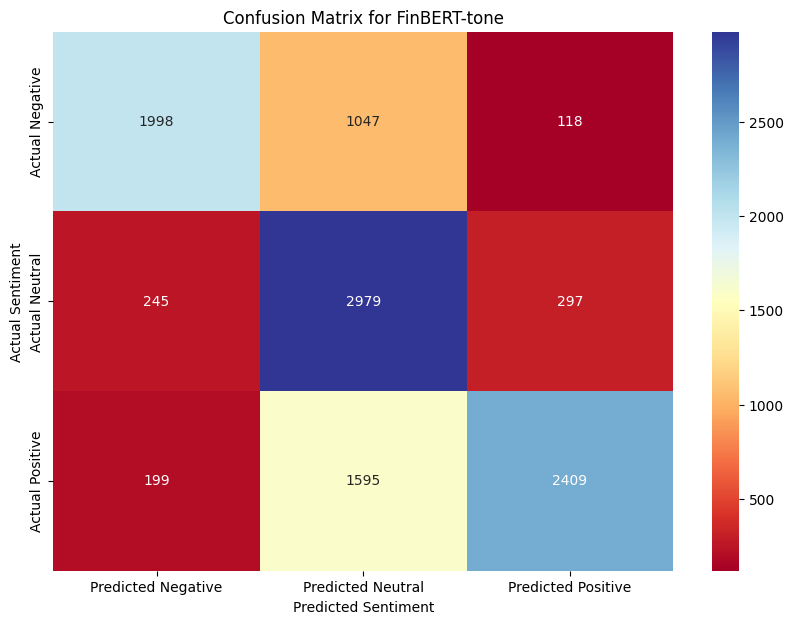

In [ ]:
cm = confusion_matrix(df_merged['Actual sentiment'], df_merged['Predicted sentiment'])
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Neutral', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='RdYlBu')
plt.title('Confusion Matrix for FinBERT-tone')
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiment')
plt.show()

# Traditional sentiment analysis

In [ ]:
data

,Title,Sentiment
0,SpiceJet to issue 6.4 crore warrants to promoters,neutral
1,MMTC Q2 net loss at Rs 10.4 crore,neutral
2,"Mid-cap funds can deliver more, stay put: Experts",positive
3,Mid caps now turn into market darlings,positive
4,"Market seeing patience, if not conviction: Pra...",neutral
...,...,...
10748,"Negative on Chambal, Advanta: Mitesh Thacker",negative
10749,"Small, Mid-cap stocks may emerge outperformers",positive
10750,Rupee slips against US dollar,negative
10751,Rupee weak against US dollar,negative


In [ ]:
# converting title into lower case
data['Title'] = data['Title'].str.lower()
#expand contarctions
import contractions

def expand_contractions(column_name):
    return contractions.fix(column_name)

data['Title'] = data['Title'].apply(expand_contractions)
# remove sepcial Charcters
def remove_characters(column_name):
    return re.sub(r'[^a-zA-Z\s]+','',column_name)

data['Title'] = data['Title'].apply(remove_characters)
# tokenize reviews
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def tokenize(column_name):
    return word_tokenize(column_name)

data['tokenized title'] = data['Title'].apply(tokenize)
pd.set_option('max_colwidth', None)
data.head()


# lammatisation
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def lemmatization(tokens):
    wnl =  WordNetLemmatizer()
    lemmatized_tokens = [wnl.lemmatize(token) for token in tokens]
    return lemmatized_tokens

data['tokenized title'] = data['tokenized title'].apply(lemmatization)
data.head()
from nltk.sentiment.util import mark_negation

def negation(tokens):
    neg_tokens = mark_negation(tokens)
    return neg_tokens

data['tokenized title'] = data['tokenized title'].apply(negation)
#remove stop words
from nltk.corpus import stopwords

nltk.download('stopwords')
print(stopwords.words('english'))
# function to remove stop words
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# apply the function
data['tokenized title'] = data['tokenized title'].apply(remove_stopwords)
# join token back together
def join_tokens(tokens):
    return ' '.join(tokens)

# apply join function
data['clean title'] = data['tokenized title'].apply(join_tokens)
# get sentiment
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# function to get sentiment
def get_sentiment(text):
    scores = sia.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
data.head()

,Title,Sentiment,tokenized title,clean title
0,spicejet to issue crore warrants to promoters,neutral,"[spicejet, issue, crore, warrant, promoter]",spicejet issue crore warrant promoter
1,mmtc q net loss at rs crore,neutral,"[mmtc, q, net, loss, r, crore]",mmtc q net loss r crore
2,midcap funds can deliver more stay put experts,positive,"[midcap, fund, deliver, stay, put, expert]",midcap fund deliver stay put expert
3,mid caps now turn into market darlings,positive,"[mid, cap, turn, market, darling]",mid cap turn market darling
4,market seeing patience if not conviction prakash diwan,neutral,"[market, seeing, patience, conviction_NEG, prakash_NEG, diwan_NEG]",market seeing patience conviction_NEG prakash_NEG diwan_NEG


In [ ]:
# apply sentiment analysis
data['predicted sentiment'] = data['clean title'].apply(get_sentiment)

# convert both sentiment coloumn to both lower case
data['Sentiment'] = data['Sentiment'].str.lower()
data['predicted sentiment'] = data['predicted sentiment'].str.lower()

#accuacy score
accuracy = accuracy_score(data['Sentiment'], data['predicted sentiment'])
print("Accuracy Score:", accuracy)

Accuracy Score: 0.5142750860225054


In [ ]:
data

,Title,Sentiment,tokenized title,clean title,predicted sentiment
0,spicejet to issue crore warrants to promoters,neutral,"[spicejet, issue, crore, warrant, promoter]",spicejet issue crore warrant promoter,neutral
1,mmtc q net loss at rs crore,neutral,"[mmtc, q, net, loss, r, crore]",mmtc q net loss r crore,negative
2,midcap funds can deliver more stay put experts,positive,"[midcap, fund, deliver, stay, put, expert]",midcap fund deliver stay put expert,neutral
3,mid caps now turn into market darlings,positive,"[mid, cap, turn, market, darling]",mid cap turn market darling,positive
4,market seeing patience if not conviction prakash diwan,neutral,"[market, seeing, patience, conviction_NEG, prakash_NEG, diwan_NEG]",market seeing patience conviction_NEG prakash_NEG diwan_NEG,neutral
...,...,...,...,...,...
10748,negative on chambal advanta mitesh thacker,negative,"[negative, chambal, advanta, mitesh, thacker]",negative chambal advanta mitesh thacker,negative
10749,small midcap stocks may emerge outperformers,positive,"[small, midcap, stock, may, emerge, outperformers]",small midcap stock may emerge outperformers,neutral
10750,rupee slips against us dollar,negative,"[rupee, slip, u, dollar]",rupee slip u dollar,neutral
10751,rupee weak against us dollar,negative,"[rupee, weak, u, dollar]",rupee weak u dollar,negative


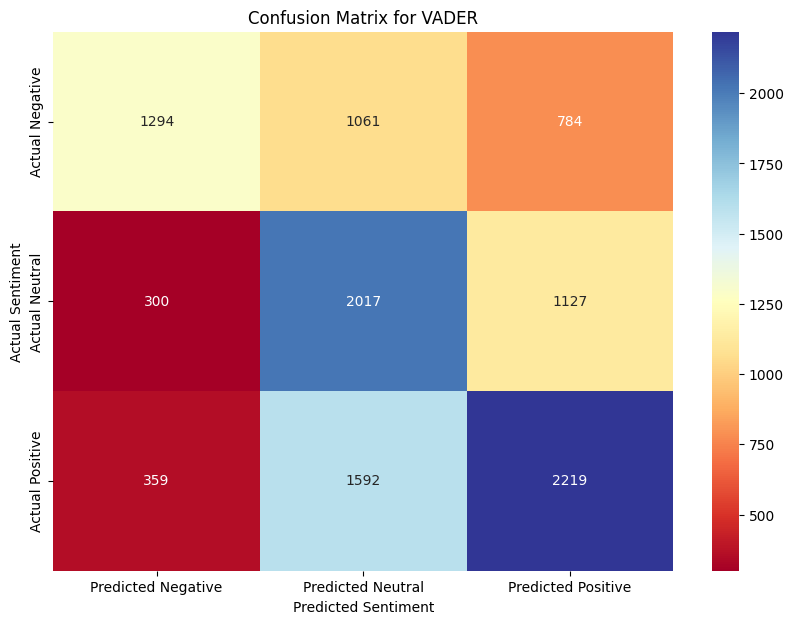

In [ ]:
# Names for the confusion matrix
cm = confusion_matrix(data['Sentiment'], data['predicted sentiment'])
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Neutral', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='RdYlBu')
plt.title('Confusion Matrix for VADER')
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiment')
plt.show()